### Python Version : Python 3.7.7

In [1]:
from sklearn.datasets import make_classification

# Generating Data

We can generate our own data using scikit-learn make_classification function.

The below code snippet generates random records each having eight features.

Each record is mapped either to 0 or 1.

In total let's generate 50000 records.

In [2]:
X, y = make_classification(n_samples=50000, n_features=8, n_informative=8, n_redundant=0, n_clusters_per_class=2, random_state=26)

# Visualizing the Data

You can visualize the data using the below code snippet. Here only first two features are used for visualization since it is a 2D plot.

Here zeros are classified as black spots and ones are classified as yellow spots

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

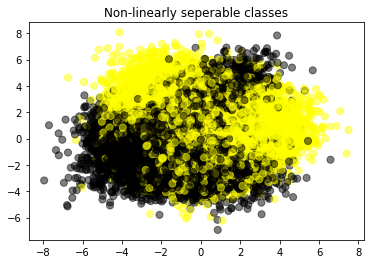

In [4]:
colors = ["black", "yellow"]
cmap = matplotlib.colors.ListedColormap(colors)

plt.figure()
plt.title("Non-linearly seperable classes")
plt.scatter(X[:,0], X[:,1], c=y, marker='o', s=50, cmap=cmap, alpha=0.5)
plt.savefig("Fig1.png", bbox_inches="tight")

# About the Data

As you have seen from the plot, the data is not linearly separable. i.e., simple logistic regression may not classify this data accurately as no clear linear boundary separates the data.

Let's see how accurately the shallow neural network classifies this data.

# Train Test Split

In order to test the accuracy of your model, you need to split the data into train and test sets.

You use the train set to train the model and test the set to test the accuracy of a trained model.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=25)
print("Shape of X_train : {} \nShape of Y_train : {}".format(X_train.shape, Y_train.shape))

Shape of X_train : (37500, 8) 
Shape of Y_train : (37500,)


# Getting Dimensions Right

In order to feed the neural network, the shape of the data has to be in the form (num_features, num_samples).

You can transpose the data as shown in the below code snippet to get the right dimensions.

Since the Y data is in the form (n,1), we use a list - reshape() function to convert it into a row vector (1,n).

In [7]:
X_train = X_train.T
Y_train = Y_train.reshape(1, len(Y_train))
X_test = X_test.T
Y_test = Y_test.reshape(1, len(Y_test))

print("After transformation")
print("Shape of X_train : {} \nShape of Y_train : {}".format(X_train.shape, Y_train.shape))

After transformation
Shape of X_train : (8, 37500) 
Shape of Y_train : (1, 37500)


# Defining Placeholders

Placeholders are meant to pass external data into the network; it may be either train or test data.

The placeholders are defined as shown in the code below.

In [8]:
import tensorflow as tf
print("Tensorflow Version : {}".format(tf.__version__))

Tensorflow Version : 1.15.0


- Placeholders must be of same shape as the input data. 
- None is passed when you are not aware of number of samples in advance.

In [9]:
def placeholders(num_features):
    A_0 = tf.placeholder(dtype=tf.float64, shape=([num_features,None]))
    Y = tf.placeholder(dtype=tf.float64, shape=([1,None]))
    return A_0, Y

# Initializing Parameters

You now need to initialize parameters, weights, and bias for hidden layer as well as output layer.

Before training, the parameters are initialized to some random values.

Usually weights are initialized with values that are normally distributed.

To initialize weights use tf.random_normal() and pass appropriate dimensions.

bias can be initialized to zero using tf.zeros() function.

the parameter num_nodes in below code represents number of parameters

In [10]:
def initialiseParameters(num_features, num_nodes):
    W1 = tf.Variable(initial_value=tf.random_normal([num_nodes, num_features], dtype=tf.float64) * 0.01)
    b1 = tf.Variable(initial_value=tf.zeros([num_nodes, 1], dtype=tf.float64))
    W2 = tf.Variable(initial_value=tf.random_normal([1, num_nodes], dtype=tf.float64) * 0.01)
    b2 = tf.Variable(initial_value=tf.zeros([1,1], dtype=tf.float64))

    return {"W1":W1, "b1":b1, "W2":W2, "b2":b2}

# Forward Propagation

Now we have place holders as well as parameters in place.

The forward propagation is implemented as follows:

- A1 is the output of hidden layer, here relu activation function is used for hidden layer. 
You can also use tanh function using tf.nn.tanh() function available in TensorFlow.

- You can see that activation function is not applied for the final output. 
The activation function will be internally applied in cost function which you will see in backpropagation.

In [11]:
def forwardPropagation(A_0, parameters):
    Z1 = tf.matmul(parameters["W1"], A_0) + parameters["b1"]
    A1 = tf.nn.relu(Z1)
    Z2 = tf.matmul(parameters["W2"], A1) + parameters["b2"]
    return Z2

# Defining Cost Function

You now know the definition of loss function L(a,y).

TensorFlow has inbuilt cost function called sigmoid_cross_entropy that provides the same implementation.

The only difference is that we are passing nonactivated output from final layer as Z2 that internally gets activated by Sigmoid function.

Labels Y is the actual output as per the data

Finally, the mean value of the loss is calculated using tf.reduce_mean().


sigmoid_cross_entropy() function of tensorflow internally performs sigmoid activation for the final layer output.

cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z2, labels=Y))

# Applying Gradient Descent

Once the cost function is defined, its time to find the derivatives of loss with respect to parameters W and b.

This is done in one step in TensorFlow.

This performs a single step of gradient descent that internally 
calculates the derivatives and updates the parameters and attempts to minimize the cost.

train_net = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [12]:
def shallowModel(X_train, Y_train, X_test, Y_test, num_nodes, learning_rate, num_iter):

    num_features = X_train.shape[0]
    A_0, Y = placeholders(num_features)

    parameters = initialiseParameters(num_features, num_nodes)
    Z2 = forwardPropagation(A_0, parameters)

    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z2, labels=Y))
    train_net = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_iter):
            _, c = sess.run([train_net, cost], feed_dict={A_0 : X_train, Y : Y_train})
            if i % 1000 == 0 :
                print("Cost value : ", c)
    
        correctPrediction = tf.equal(tf.round(tf.sigmoid(Z2)), Y)

        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correctPrediction, "float"))
        print("Accuracy on test set : ", accuracy.eval({A_0 : X_test, Y : Y_test}))

# Program Flow

Initialize the placeholders and parameters using the function defined.

Call forward propagation function and assign the final output to Z2.

Using Z2 and actual output Y, calculate cost function using sigmoid_cross_entropy function.

Call GradientDescetOptimizer to update parameters such that it minimizes cost.

Initialise TensorFlow session.

Run the session by passing the values that are to be evaluated and returned. Fill the place holders with actual train data.

Run the above step for number of times till there is no significant change in the cost value.

The .eval() function inside the session uses update parameters of W and b to calculate the accuracy of the model against test data.

------------------------------------------------------------------------------------------------------------

<h1>Implementing the model</h1>

The model below creates a network with one hidden layer with 8 nodes. Let the learning rate be 0.2 and number of iterations be 10000.

At every 1000 iterating you can see that cost value is approaching close to zero.

The model is able to classify the test data set with 95% accuracy.

In [13]:
shallowModel(X_train, Y_train, X_test, Y_test, 8, 0.2, 10000)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Cost value :  0.6930824065936931
Cost value :  0.19880247479505095
Cost value :  0.17784898856882458
Cost value :  0.1673232882596748
Cost value :  0.16024601238750572
Cost value :  0.15703038112190504
Cost value :  0.15525581015606624
Cost value :  0.15360663069314653
Cost value :  0.15214065844411132
Cost value :  0.15070409758959355
Accuracy on test set :  0.94568
